In [19]:
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
from PIL import Image
import os
import shutil
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras import regularizers
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from keras.callbacks import Callback
from scipy.stats import sem, t
from scipy import mean
import seaborn as sns
from scipy import ndimage

In [20]:
original_dir = 'C:\\Users\\Anton.Lahunou\\detect_people_task\\brainwash'

In [21]:
work_dir = 'C:\\Users\\Anton.Lahunou\\detect_people_task\\brainwash\\work'

In [22]:
aug_dir = os.path.join(work_dir, 'aug')
os.mkdir(aug_dir)

In [23]:
work_pos_dir = os.path.join(work_dir, 'pos')
os.mkdir(work_pos_dir)

In [24]:
work_neg_dir = os.path.join(work_dir, 'neg')
os.mkdir(work_neg_dir)

In [25]:
txt_list = ['brainwash_test.txt', 'brainwash_train.txt', 'brainwash_val.txt']

In [26]:
def split_string(str):
    start = str.find('/') + 1
    end = str.find('png') + 3
    png_name = str[start:end]
    folder = str[1:start-1]
    if str[end+1] == ';':
        is_here = False
    else:
        is_here = True
    return folder, png_name, is_here

In [27]:
str1 = '"brainwash_11_13_2014_images/00026000_640x480.png": (57.0, 258.0, 82.0, 286.0), (76.0, 239.0, 98.0, 266.0), (97.0, 204.0, 118.0, 227.0), (480.0, 236.0, 522.0, 281.0), (241.0, 244.0, 297.0, 294.0), (326.0, 207.0, 368.0, 245.0), (199.0, 185.0, 224.0, 210.0), (124.0, 172.0, 145.0, 195.0), (237.0, 158.0, 256.0, 177.0), (228.0, 164.0, 250.0, 188.0), (292.0, 170.0, 311.0, 189.0), (294.0, 159.0, 309.0, 178.0), (385.0, 126.0, 403.0, 143.0);'
str2 = '"brainwash_11_13_2014_images/00100000_640x480.png";'

In [28]:
split_string(str1)

('brainwash_11_13_2014_images', '00026000_640x480.png', True)

In [29]:
split_string(str2)

('brainwash_11_13_2014_images', '00100000_640x480.png', False)

In [30]:
for txt_name in txt_list:
    f = open(os.path.join(original_dir, txt_name))
    images_png = f.readlines()
    for i in images_png:
        folder, png_name, is_here = split_string(i)
        dir_name = original_dir + '\\' + folder
        full_image_name = os.path.join(dir_name, png_name)
        if is_here:
            shutil.copy(full_image_name, work_pos_dir)
        else:
            shutil.copy(full_image_name, work_neg_dir)

In [31]:
print('Total pos images:', len(os.listdir(work_pos_dir)))
print('Total neg images:', len(os.listdir(work_neg_dir)))

Total pos images: 8789
Total neg images: 329


In [32]:
i = 1
for img in os.listdir(work_pos_dir):
    if i <= 7700:
        os.remove(work_pos_dir + '\\' + img)
    else:
        break
    i += 1

In [39]:
print('Total pos images:', len(os.listdir(work_pos_dir)))
print('Total neg images:', len(os.listdir(work_neg_dir)))

Total pos images: 1089
Total neg images: 296


In [40]:
neg_datagen = ImageDataGenerator(width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [41]:
datagen = ImageDataGenerator(rescale=1./255)

In [42]:
for image in os.listdir(work_neg_dir):
    img = np.expand_dims(ndimage.imread(work_neg_dir + '\\' + image), 0)
    neg_datagen.fit(img)
    for x, val in zip(neg_datagen.flow(img, save_to_dir=aug_dir, save_format='png', batch_size=3), range(3)):
        pass

c:\users\anton.lahunou\nn_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


In [43]:
print('Total pos images:', len(os.listdir(work_pos_dir)))
print('Total neg images:', len(os.listdir(work_neg_dir)))

Total pos images: 1089
Total neg images: 296


In [44]:
work_work_dir = os.path.join(work_dir, 'work_work')
os.mkdir(work_work_dir)

In [45]:
ww_pos_dir = os.path.join(work_work_dir, 'pos')
os.mkdir(ww_pos_dir)

In [47]:
ww_neg_dir = os.path.join(work_work_dir, 'neg')
os.mkdir(ww_neg_dir)

In [52]:
for image in os.listdir(work_pos_dir):
    dir_name = work_pos_dir + '\\' + image
    shutil.copy(dir_name, ww_pos_dir)

In [53]:
for image in os.listdir(work_neg_dir):
    dir_name = work_neg_dir + '\\' + image
    shutil.copy(dir_name, ww_neg_dir)

In [54]:
for image in os.listdir(aug_dir):
    dir_name = aug_dir + '\\' + image
    shutil.copy(dir_name, ww_neg_dir)

In [55]:
print('Total pos images:', len(os.listdir(ww_pos_dir)))
print('Total neg images:', len(os.listdir(ww_neg_dir)))

Total pos images: 1089
Total neg images: 1417


In [56]:
generator = datagen.flow_from_directory(work_work_dir, target_size=(150, 150), batch_size=len(os.listdir(ww_pos_dir))+len(os.listdir(ww_neg_dir)), shuffle=True, class_mode='binary')

Found 2506 images belonging to 2 classes.


In [57]:
for data_batch, labels_batch in generator:
    images = data_batch
    labels = labels_batch
    break

###  Конструирование модели

In [58]:
def build_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
    return model

In [59]:
k = 6
samples = len(images) // k

In [61]:
train_data = images[samples:]
train_targets = labels[samples:]
test_data = images[:samples]
test_targets = labels[:samples]
model = build_cnn()
history = model.fit(train_data, train_targets, epochs=50, batch_size=64, validation_split=0.2)
results = model.evaluate(test_data, test_targets)

Train on 1671 samples, validate on 418 samples
Epoch 1/50
1671/1671 [==============================] - 95s 57ms/step - loss: 10.9419 - acc: 0.7020 - val_loss: 9.4662 - val_acc: 0.8876
Epoch 2/50
1671/1671 [==============================] - 99s 59ms/step - loss: 8.7282 - acc: 0.8510 - val_loss: 8.1977 - val_acc: 0.5837
Epoch 3/50
1671/1671 [==============================] - 98s 58ms/step - loss: 7.2954 - acc: 0.8863 - val_loss: 6.5781 - val_acc: 0.9187
Epoch 4/50
1671/1671 [==============================] - 100s 60ms/step - loss: 6.1204 - acc: 0.9138 - val_loss: 5.5382 - val_acc: 0.9474
Epoch 5/50
1671/1671 [==============================] - 101s 60ms/step - loss: 5.1762 - acc: 0.9288 - val_loss: 4.6977 - val_acc: 0.9665
Epoch 6/50
1671/1671 [==============================] - 96s 58ms/step - loss: 4.3651 - acc: 0.9485 - val_loss: 4.0815 - val_acc: 0.8828
Epoch 7/50
1671/1671 [==============================] - 106s 64ms/step - loss: 3.7158 - acc: 0.9533 - val_loss: 3.3809 - val_acc: 0.97

In [62]:
train_targets

array([1., 0., 0., ..., 1., 0., 1.], dtype=float32)

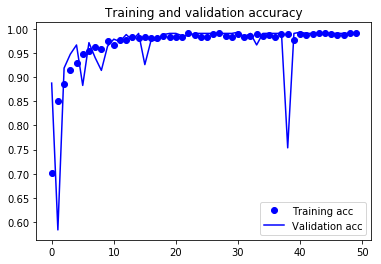

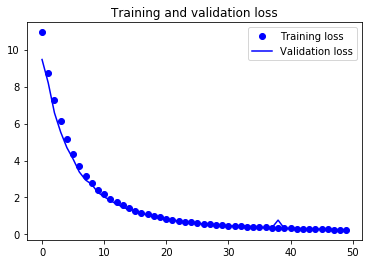

In [63]:
plt.plot(history.history['acc'], 'bo', label='Training acc')
plt.plot(history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(history.history['loss'], 'bo', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [64]:
results

[0.2915691701914195, 0.9832134292565947]